In [1]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import constants
import model_utils

In [2]:
df = pd.read_json('data/translated/emotions/emotions_dataset_pl.json')
df

,text,emotions,text_pl
0,i feel awful about it too because it s my job ...,sadness,"Też czuję się z tym okropnie, bo moim zadaniem..."
1,im alone i feel awful,sadness,Jestem sama czuję się okropnie
2,ive probably mentioned this before but i reall...,joy,"Prawdopodobnie wspomniałem o tym wcześniej, al..."
3,i was feeling a little low few days back,sadness,Czułem się trochę nisko kilka dni temu
4,i beleive that i am much more sensitive to oth...,love,"Wyobrażam sobie, że jestem znacznie bardziej w..."
...,...,...,...
39995,i witness what i feel helpless to change i tak...,sadness,"Jestem świadkiem tego, co czuję się bezradny z..."
39996,i feel unwelcome and i feel very self consciou...,sadness,Czuję się niemile widziany i czuję się bardzo ...
39997,i feel like boston is so romantic when its rai...,love,"Czuję, że Boston jest taki romantyczny, kiedy ..."
39998,i thought sure i was coming down with somethin...,joy,"Myślałem, że z czymś zejdę, ale dziś rano czuj..."


In [3]:
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,sadness,"Też czuję się z tym okropnie, bo moim zadaniem..."
1,sadness,Jestem sama czuję się okropnie
2,joy,"Prawdopodobnie wspomniałem o tym wcześniej, al..."
3,sadness,Czułem się trochę nisko kilka dni temu
4,love,"Wyobrażam sobie, że jestem znacznie bardziej w..."
...,...,...
39995,sadness,"Jestem świadkiem tego, co czuję się bezradny z..."
39996,sadness,Czuję się niemile widziany i czuję się bardzo ...
39997,love,"Czuję, że Boston jest taki romantyczny, kiedy ..."
39998,joy,"Myślałem, że z czymś zejdę, ale dziś rano czuj..."


In [4]:
surprise_count = len(df.loc[df['emotions'] == 'surprise'])

joy = df.loc[df['emotions'] == 'joy'].iloc[:surprise_count]
sadness = df.loc[df['emotions'] == 'sadness'].iloc[:surprise_count]
anger = df.loc[df['emotions'] == 'anger'].iloc[:surprise_count]
fear = df.loc[df['emotions'] == 'fear'].iloc[:surprise_count]
love = df.loc[df['emotions'] == 'love'].iloc[:surprise_count]
surprise = df.loc[df['emotions'] == 'surprise']

In [5]:
frames = [joy, sadness, anger, fear, love, surprise]
equal_dataset = pd.concat(frames)

np.random.shuffle(equal_dataset.values)
equal_dataset

,emotions,text_pl
2,anger,"Myślę o tym i czuję się zniesmaczony sobą, pon..."
6,joy,"Miałem wiele obaw o wymuszanie tego problemu, ..."
7,surprise,"Uwielbiam sposób, w jaki rozpraszasz słowa jak..."
8,anger,Czuję się śmiesznie pogorszony
12,sadness,"Powiedziałem funkcjonariuszowi, że cierpię na ..."
...,...,...
39774,surprise,Widzę to czuję dziwne uczucie rzeczy pędzących...
39788,anger,"Podoba mi się sposób w jaki mówisz, że cię wku..."
39901,joy,"Rozumiem to, ale jestem tak śmierdząco wrażliw..."
39913,sadness,"Zawsze czuję się karana za coś, co musi przez ..."


In [6]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = equal_dataset.iloc[:40000]

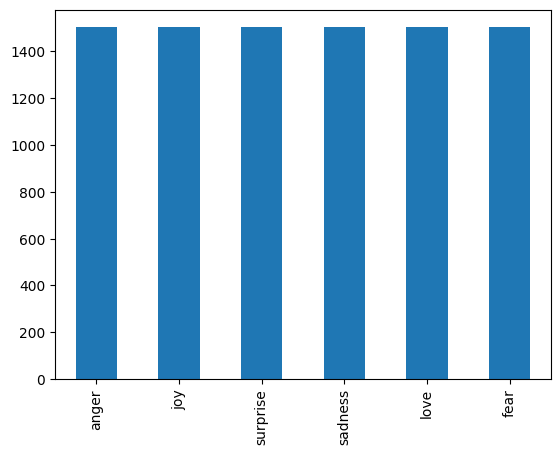

In [7]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [8]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [9]:
df = df.replace({"emotions": ordered_class_labels})

In [ ]:
!pip install datasets
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

In [ ]:
!pip install transformers
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
def tokenize_function(example):
    return tokenizer(example["text_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9018 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5)

In [14]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["emotions"]
batch_size = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [15]:
# Model parameters
training_number = 1
model_name = "emotions_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"documentation/models/emotions_pl_bert/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [16]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [17]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [18]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
902/902 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.7149
Epoch 1: saving model to training_checkpoints/emotions_pl_bert/training_1/cp-0001.ckpt
902/902 [==============================] - 222s 182ms/step - loss: 0.8103 - accuracy: 0.7149 - val_loss: 0.5423 - val_accuracy: 0.8237
Epoch 2/10
902/902 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8736
Epoch 2: saving model to training_checkpoints/emotions_pl_bert/training_1/cp-0002.ckpt
902/902 [==============================] - 125s 139ms/step - loss: 0.3961 - accuracy: 0.8736 - val_loss: 0.5766 - val_accuracy: 0.8304
Epoch 3/10
902/902 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9206
Epoch 3: saving model to training_checkpoints/emotions_pl_bert/training_1/cp-0003.ckpt
902/902 [==============================] - 127s 140ms/step - loss: 0.2381 - accuracy: 0.9206 - val_loss: 0.5188 - val_accuracy: 0.8348
Epoch 4/10
902/902 [==========================

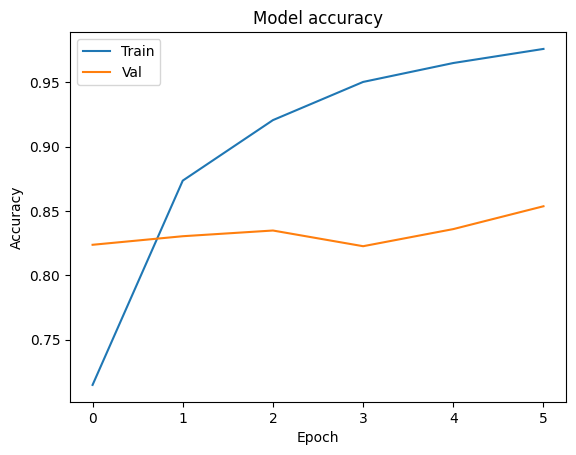

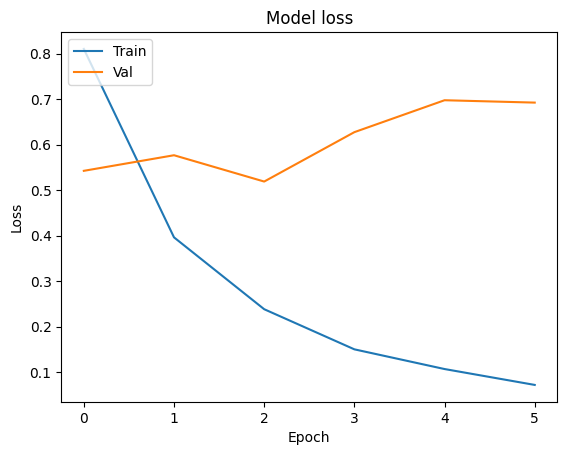

In [21]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [22]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [23]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

In [24]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

113/113 [==============================] - 5s 45ms/step - loss: 0.5687 - accuracy: 0.8359


[0.568745493888855, 0.8359201550483704]

In [25]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

113/113 [==============================] - 10s 59ms/step


In [26]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics_for_emotions(
    class_actual=tokenized_test_dataset['emotions'],
    class_preds=class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.835920177383592
Recall score:  0.835920177383592
F1 score:  0.835920177383592


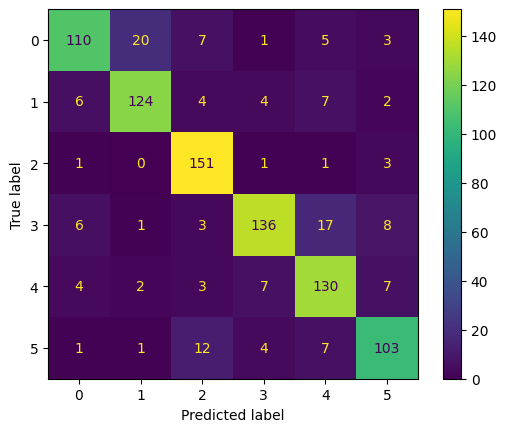

In [27]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [28]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['text_pl'],
                                              class_actual=raw_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Miałem wiele obaw o wymuszanie tego problemu, ale modliłem się o to i nie tylko byłem szczery z moimi uczuciami, byłem przekonany, że mam rację.
            - PREDICTED VALUE: 3
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: Czuję się śmiesznie pogorszony
            - PREDICTED VALUE: 3
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Czuję się coraz bardziej wzburzony
            - PREDICTED VALUE: 5
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Osobiście uważam, że system, który nie może zagwarantować, że żaden niewinny obywatel nigdy nie zostanie skazany za błąd, powinien nakładać na skazanych wyroki, które można odwrócić, jeśli taki błąd później wyjdzie na jaw.
            - PREDICTED VALUE: 1
            - 

In [29]:
!zip -r documentation.zip documentation/models

  adding: documentation/models/ (stored 0%)
  adding: documentation/models/.ipynb_checkpoints/ (stored 0%)
  adding: documentation/models/emotions_pl_bert/ (stored 0%)
  adding: documentation/models/emotions_pl_bert/figures/ (stored 0%)
  adding: documentation/models/emotions_pl_bert/figures/training_1_loss.png (deflated 9%)
  adding: documentation/models/emotions_pl_bert/figures/training_1_accuracy.png (deflated 9%)
  adding: documentation/models/emotions_pl_bert/figures/.ipynb_checkpoints/ (stored 0%)
  adding: documentation/models/emotions_pl_bert/figures/training_1_confmatrix.png (deflated 12%)
  adding: documentation/models/emotions_pl_bert/.ipynb_checkpoints/ (stored 0%)


In [30]:
from google.colab import files
files.download("documentation.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>